In [121]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
sys.path.append(r"C:\Users\mikek\OneDrive\Project\python-packages")


from DLScommonTools import *
from unpackConfigurationsMK import *
from sdtools.code_comparison.solps_pp import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# From D. Moulton on calculating parallel heat flux

    Ah, this is not as simple as it sounds. The total poloidal energy flux density is "fht" and is calculated in $SOLPSTOP/modules/B2.5/src/b2aux/b2xpen.F - it's the sum of all plasma contributions, including the potential (to recombine at the target surface). This is the same naming convention as in the manual (the b2plot part), and is stored in balance.nc. If you don't want the potential part, then subtract off 13.6eV*fna_tot(:,:,1,2). I don't store fhi and fhe separately, but they are the sum of all the fhi_xxx and fhe_xxx contributions in the balance.nc file. Note that these sum to the poloidal
    internal
    energy flux, though. When doing the sum of fhi_xxx+fhe_xxx, you need to multiply the "fhe_32" and "fhi_32" parts by 5/3 in order to get the right coefficient in front of the convective part for the total energy flux. Once you do that, you should get the same as fht(:,:,1)-13.6eV*fna_tot(:,:,1,2).

- fhe_32: you must multiply by 5/3 to get the total advection term 5/2*n*T*v_par (this is cause you're advecting internal energy and pressure).
- You need to also add kinetic energy: kinrgy*ti*fna_tot which is the 1/2 mnVxV_par^2 part
- Can probably ignore the potential since it'll be small at the X-point


**Method for area calculation:**
```

 function area_divide = calc_area(balfile,areatype)

    % Shorthand for geometry variables:
    leftix = ncread(balfile,'leftix')+2;
    leftiy = ncread(balfile,'leftiy')+2;
    dv = ncread(balfile,'vol');
    B = ncread(balfile,'bb');
    hx = ncread(balfile,'hx');
    nx = size(dv,1);
    ny = size(dv,2);
    
    switch areatype
        case 'parallel'        
            % Parallel area at cell centres:
            apll = dv./hx.*abs(B(:,:,1)./B(:,:,4));
            % Map to left cell face:
            area_divide = zeros(nx,ny);
            for iy=1:ny
                for ix=1:nx
                    if leftix(ix,iy)<1
                        continue;
                    end
                    area_divide(ix,iy) = (apll(leftix(ix,iy),leftiy(ix,iy))*dv(ix,iy)+...
                                          apll(ix,iy)*dv(leftix(ix,iy),leftiy(ix,iy)))/...
                                         (dv(ix,iy)+dv(leftix(ix,iy),leftiy(ix,iy)));
                end
            end
        case 'contact'
            gs = ncread(balfile,'gs');
            area_divide = gs(:,:,1); % Poloidal contact area
        case 'none'
            area_divide = ones(size(dv,1),size(dv,2)); % No division by area
        otherwise
            error('Area type ''%s'' not supported.',areatype);
    end

end
```

# Read balance file

In [4]:
balancepath = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file"

In [135]:
slc = self = SOLPScase(balancepath)

In [15]:
slc.find_param("fna")

fna_ch
fna_drift
fna_nanom
fna_panom
fna_pinch
fna_pll
fna_pschused
fna_tot
fna_vsprcur


In [22]:
plt.close("all")
%matplotlib inline

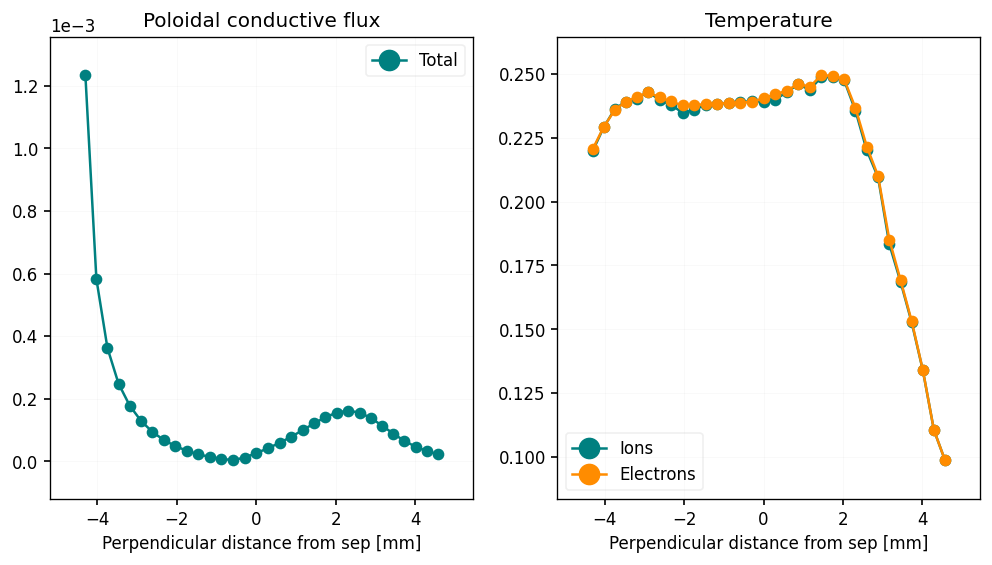

In [24]:

p =(-1, slice(1,-1))
param = "fhi_cond"

df = pd.DataFrame()
df["hx"] = self.g["hx"][p[0], p[1]].cumsum()
df["dist"] = (df["hx"] - df["hx"][self.g["sep"]]) * 1000   # mm

df["R"] = self.g["R"][p[0], p[1]]
df["Z"] = self.g["Z"][p[0], p[1]]
df["area"] = df["hx"] * 2 * np.pi * df["R"]


df["fhix_cond"] = self.bal["fhi_cond"][:][0].transpose()[-2, 1:-1]  # Ion poloidal conductive heat flux [W]
df["fhex_cond"] = self.bal["fhe_cond"][:][0].transpose()[-2, 1:-1]  # Electron poloidal conductive heat flux [W]
df["fht"] = self.bal["fht"][:][0].transpose()[-2, 1:-1]  # Total energy flux [W] (internal + potential, no kinetic I don't think)
# df["fnax_tot"] = self.bal["fna_tot"][:][0].transpose()[-2, 1:-1]  # Particle flux [??]
df["te"] = self.bal["te"][:].transpose()[-2, 1:-1] / constants("q_e")  # [eV]
df["ti"] = self.bal["ti"][:].transpose()[-2, 1:-1] / constants("q_e")  # [eV]

tot_flux = df["fht"] / df["area"] * 1e-9  # [GW/m^2]


fig, axes = plt.subplots(1,2, figsize = (10,5))
ax = axes[0]
ax.set_title("Poloidal conductive flux")
# ax.plot(df["dist"], df["fhix_cond"], marker = "o", label = "Ions")
# ax.plot(df["dist"], df["fhex_cond"], marker = "o", label = "Electrons")
ax.plot(df["dist"], tot_flux, marker = "o", label = "Total")
ax.set_ylabel("Power [W]")

ax = axes[1]
ax.set_title("Temperature")
ax.plot(df["dist"], df["ti"], marker = "o", label = "Ions")
ax.plot(df["dist"], df["te"], marker = "o", label = "Electrons")
# ax.set_ylabel("

for ax in axes.flatten():
    ax.set_xlabel("Perpendicular distance from sep [mm]")
    ax.set_ylabel("")
    ax.legend()


In [84]:
self.find_param("b")

b2mndr_eirene
b2mndr_hz
b2npht_shei_bal
b2nxdv_smo_bal
b2sian_smo_bal
b2siav_smovh_bal
b2siav_smovi_bal
b2siav_smovv_bal
b2sicf_smo_bal
b2sifr_smoch_bal
b2sifr_smofrea_bal
b2sifr_smofria_bal
b2sifr_smotf_cthe_bal
b2sifr_smotf_cthi_bal
b2sifr_smotf_ehxp_bal
b2sifr_smotfea_bal
b2sifr_smotfia_bal
b2sigp_pstat_bal
b2sigp_pstate_bal
b2sigp_pstati_bal
b2sigp_smogp_bal
b2sigp_smogpe_bal
b2sigp_smogpgr_bal
b2sigp_smogpi_bal
b2sihs_diaa_bal
b2sihs_diae_bal
b2sihs_divua_bal
b2sihs_divue_bal
b2sihs_exba_bal
b2sihs_exbe_bal
b2sihs_fraa_bal
b2sihs_joule_bal
b2sihs_visa_bal
b2srdt_she_bal
b2srdt_shi_bal
b2srdt_smo_bal
b2srdt_sna_bal
b2srsm_she_bal
b2srsm_shi_bal
b2srsm_smo_bal
b2srsm_sna_bal
b2srst_she_bal
b2srst_shi_bal
b2srst_smo_bal
b2srst_sna_bal
b2stbc_she_bal
b2stbc_shi_bal
b2stbc_smo_bal
b2stbc_sna_bal
b2stbm_she_bal
b2stbm_shi_bal
b2stbm_smo_bal
b2stbm_sna_bal
b2stbr_bas_she_bal
b2stbr_bas_shi_bal
b2stbr_bas_smo_bal
b2stbr_bas_sna_bal
b2stbr_first_flight_she_bal
b2stbr_first_flight_shi_bal
b

In [109]:
%matplotlib widget


In [277]:
slc = self = SOLPScase(balancepath)

In [203]:
# area = self.g["R"] * 2 * np.pi * self.g["hx"]
# Bpitch = abs(self.g["Bpol"] / self.g["Btot"])

## leftix and leftiy are the indices of the next cell to the left in poloidal and radial
## However SOLPS runs -1:nx where -1 is the guard cell and for the guard cell at the lower inner
## target leftix is -2
leftix = self.bal["leftix"] + 2   # Was 2 in matlab TODO figure this out
leftiy = self.bal["leftiy"] + 2
Bpol = self.g["Bpol"]
Btot = self.g["Btot"]
dv = self.bal["vol"]
hx = self.g["hx"] 
nx, ny = self.g["nx"], self.g["ny"]

apll = dv / hx * abs(Bpol / Btot) 
area_divide = np.zeros((nx, ny))

for iy in range(0,ny-1):
    for ix in range(0,nx-1):
        if leftix[ix, iy] < 1:
            continue
        
        area_divide[ix, iy] = (apll[leftix[ix, iy], leftiy[ix, iy]] * dv[ix, iy] + \
                              apll[ix, iy] * dv[leftix[ix, iy], leftiy[ix, iy]]) / \
                              (dv[ix, iy] + dv[leftix[ix, iy], leftiy[ix, iy]])
        # area_divide(ix, iy) = (apll(leftix(ix,iy),leftiy(ix,iy))*dv(ix,iy)      \
        #                        + apll(ix,iy)*dv(leftix(ix,iy),leftiy(ix,iy)))   \
        #                        / (dv(ix,iy)+dv(leftix(ix,iy),leftiy(ix,iy)))


In [269]:
outer_ids[0] + self.g["upper_break"]

array([ 86, 111], dtype=int64)

## 2D plot of the heat flux

Data shape: (148, 34)
Grid shape: (148, 34)


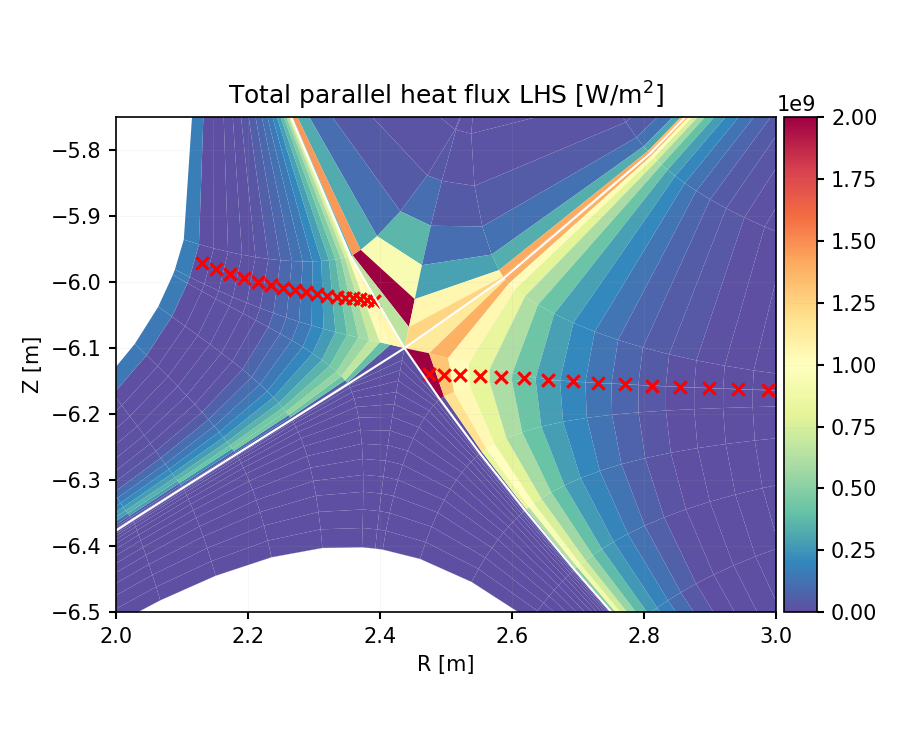

In [416]:
plt.close("all")
fig, ax = plt.subplots(dpi = 150)

fht = abs(self.bal["fht"][:,:,0])
pflux = abs(self.bal["fna_tot"][:,:,0,1])   # I think 1 is ions?

total_flux = fht/area_divide
energy_flux = (fht - pflux * 13.6 * constants("q_e"))/ area_divide

slc.plot_2d("Total parallel heat flux LHS [$W/m^2$]", 
            fig = fig, 
            ax = ax, 
            antialias = True,
            data = energy_flux,
            logscale = False,
            vmin = 0,
            vmax = 2e9
            )
R, Z = self.g["R"], self.g["Z"]
sep = self.g["sep"]

s_outer = (xpoints[3],slice(sep, -2))   
s_inner = (xpoints[0],slice(sep, -2))

ax.scatter(R[s_inner], Z[s_inner], marker = "x", color = "r")
ax.scatter(R[s_outer], Z[s_outer], marker = "x", color = "r")

ax.set_ylim(-6.5, -5.75)
ax.set_xlim(2,3)
fig.tight_layout()


## 1D plot at xpoint for inner and outer
- The slice starts from separatrix and goes outwards, so 0 is already sep

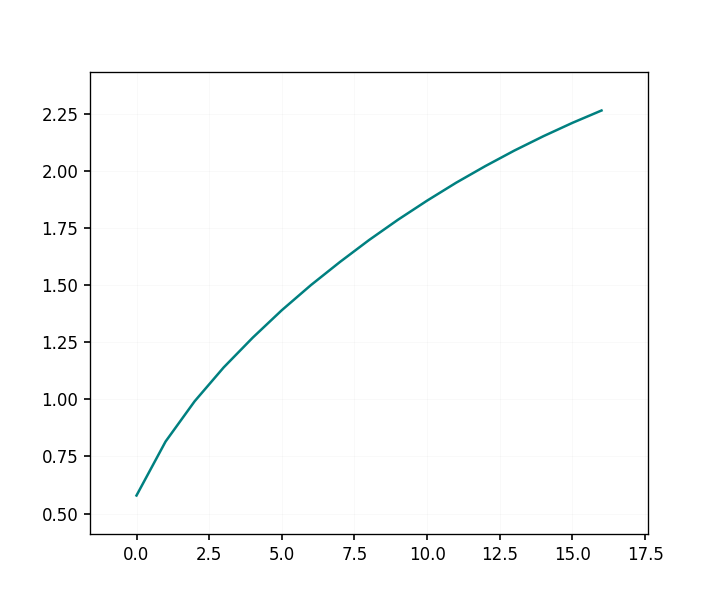

In [396]:
fig, ax = plt.subplots()

dist_inner = hx[s_inner].cumsum()
# dist_inner -= dist_inner[0]
ax.plot(dist_inner)

In [406]:
print(f"Total inner heat flow: {fht[s_inner].sum() * 1e-6:.3f} MW")
print(f"Total outer heat flow: {fht[s_outer].sum() * 1e-6:.3f} MW")
print(f"Above times two: {(abs(fht[s_inner].sum()) + abs(fht[s_outer].sum()))*2 * 1e-6:.3f} MW")

Total inner heat flow: -8.917 MW
Total outer heat flow: 47.727 MW
Above times two: 113.289 MW


Text(0.5, 1.0, 'Total parallel heat flux (fht - fna_tot*13.6)')

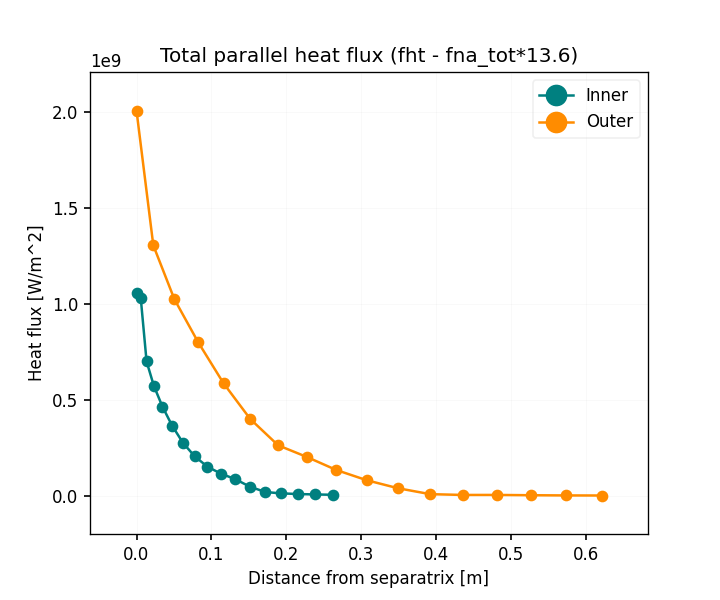

In [418]:
fig, ax = plt.subplots()

R, Z = self.g["R"], self.g["Z"]
sep = self.g["sep"]
xpoints = self.g["xpoints"]
hy = self.g["hy"]

dist_outer = hy[s_outer].cumsum()
dist_outer -= dist_outer[0]

dist_inner = hy[s_inner].cumsum()
dist_inner -= dist_inner[0]

# dist = hx.cumsum() - hx.cumsum()[:,sep]

ax.plot(dist_inner, energy_flux[s_inner], marker = "o", label = "Inner")
ax.plot(dist_outer, energy_flux[s_outer], marker = "o", label = "Outer")
# ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Heat flux [W/m^2]")
ax.set_xlabel("Distance from separatrix [m]")
ax.set_title("Total parallel heat flux (fht - fna_tot*13.6)")

In [420]:
energy_flux[s_outer].max()

2008856394.4826715

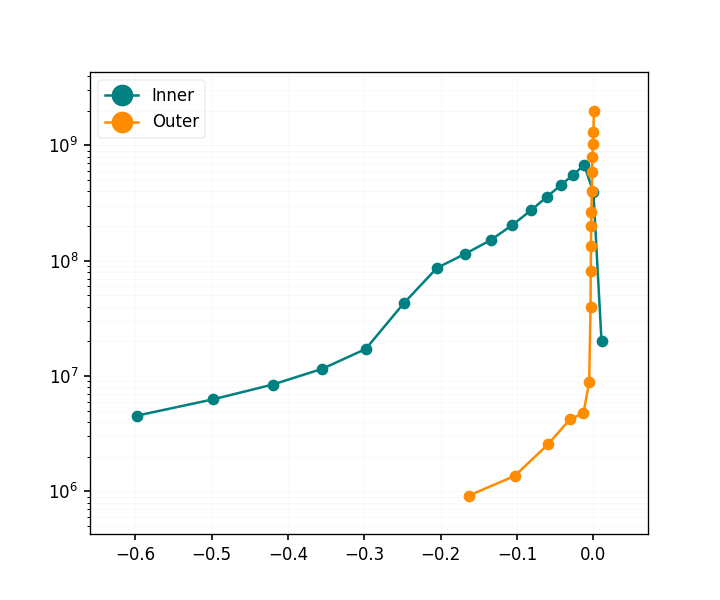

In [340]:
fig, ax = plt.subplots()

R, Z = self.g["R"], self.g["Z"]
sep = self.g["sep"]
xpoints = self.g["xpoints"]
hx = self.g["hx"]

s_inner = (xpoints[0]-1,slice(sep, -2))
s_outer = (xpoints[3],slice(sep, -2))

dist_inner = hx[s_inner].cumsum()
dist_inner -= dist_inner[sep]

dist_outer = hx[s_outer].cumsum()
dist_outer -= dist_outer[sep]

# dist = hx.cumsum() - hx.cumsum()[:,sep]

sel = (xpoints[0],slice(1, sep))
ax.plot(dist_inner[::-1], tflux[s_inner], marker = "o", label = "Inner")
ax.plot(dist_outer[::-1], tflux[s_outer], marker = "o", label = "Outer")
ax.set_yscale("log")
ax.legend()

In [253]:
x = range(self.g["nx"])
R = self.g["R"][:,self.g["sep"]]

inner_R = self.g["R"][slice(None, self.g["upper_break"]),self.g["sep"]]
inner_x = np.array(range(self.g["upper_break"]))


outer_R = self.g["R"][slice(self.g["upper_break"], None),self.g["sep"]]
outer_x = np.array(range(self.g["upper_break"], self.g["nx"]))

import scipy

inner_ids = scipy.signal.find_peaks(inner_R, threshold = 0.001)
outer_ids = scipy.signal.find_peaks(outer_R*-1, threshold = 0.001)

if (len(inner_ids[0]) != 2) or (len(outer_ids[0]) != 2):
    raise Exception("Issue in peak finder")

# fig, axes = plt.subplots(1,2, figsize = (8,4))
# ax = axes[0]
# ax.plot(inner_x, inner_R)
# for i in inner_ids[0]:
#     ax.scatter(inner_x[i], inner_R[i])
# ax = axes[1]
# ax.plot(outer_x, outer_R)
# for i in outer_ids[0]:
#     ax.scatter(outer_x[i], outer_R[i])

xpoints = [inner_ids[0][0], inner_ids[0][1], outer_ids[0][0], outer_ids[0][1]]



In [222]:
peak_ids[0]

array([13, 23, 26, 36], dtype=int64)

Data shape: (34, 148)
Grid shape: (148, 34)


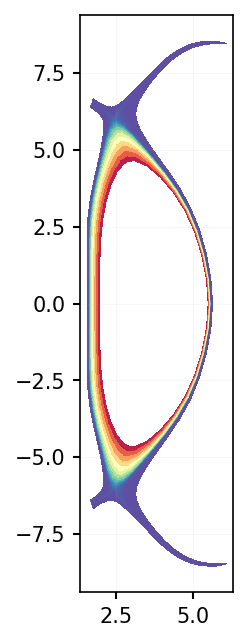

In [58]:
ax = None
norm = None
cmap = "Spectral_r"
antialias = False
linecolor = "k"
linewidth = 0
vmin = None
vmax = None
logscale = False
alpha = 1

data = self.bal["te"][:]

# if vmin == None:
#     vmin = data.min()
# if vmax == None:
#     vmax = data.max()
# if norm == None:
#     norm = create_norm(logscale, norm, vmin, vmax)
# if ax == None:
fig, ax = plt.subplots(dpi = 150)

crx = self.bal["crx"][:]
cry = self.bal["cry"][:]

Nx = crx.shape[2]
Ny = crx.shape[1]

print(f"Data shape: {data.shape}")
print(f"Grid shape: {Nx, Ny}")
# print(cry.shape)


# In hermes-3 and needed for plot: lower left, lower right, upper right, upper left, lower left
# SOLPS crx structure: lower left, lower right, upper left, upper right
# So translating crx is gonna be 0, 1, 3, 2, 0
# crx is [corner, Y(radial), X(poloidal)]
idx = [np.array([0, 1, 3, 2, 0])]

# Make polygons
patches = []
for i in range(Nx):
    for j in range(Ny):
        p = mpl.patches.Polygon(
            np.concatenate([crx[:,j,i][tuple(idx)], cry[:,j,i][tuple(idx)]]).reshape(2,5).T,
            
            fill=False,
            closed=True,
        )
        patches.append(p)
        
# Polygon colors
colors = data.transpose().flatten()
polys = mpl.collections.PatchCollection(
    patches, alpha = alpha, norm = norm, cmap = cmap, 
    antialiaseds = antialias,
    edgecolors = linecolor,
    linewidths = linewidth,
    joinstyle = "bevel")

polys.set_array(colors)

# if fig != None:
#     fig.colorbar(polys)
# ax.scatter([1,2,4], [1,2,3])
ax.autoscale()

xmin, xmax = crx.min(), crx.max()
ymin, ymax = cry.min(), cry.max()
xspan = xmax - xmin
yspan = ymax - ymin

ax.set_xlim(xmin - xspan*0.05, xmax + xspan*0.05)
ax.set_ylim(ymin - yspan*0.05, ymax + yspan*0.05)
ax.add_collection(polys)
ax.set_aspect("equal")

In [54]:
crx.max()

6.10007739

In [35]:
fig.show()

C:\Users\mikek\AppData\Local\Temp\ipykernel_84460\89474557.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [24]:
%matplotlib inline
plt.close("all")

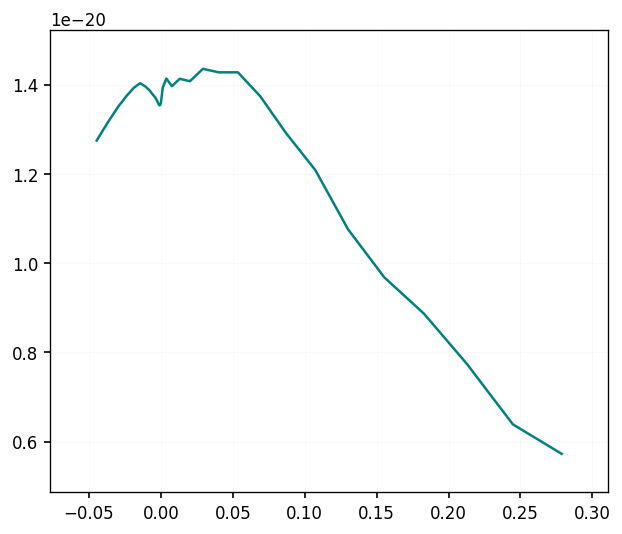

In [25]:

# df.plot(x="dist", y=param)
